Use the IMDB dataset packaged with Keras. It has already been labelled, where each word has been turned into an integer. We need to modify `np.load` to set `allow_pickle=True` otherwise we can't load the data. When loading the imdb data we use `num_words=10000` so that we only get the 10k most frequently used words. Although we lose information to train the neural net it allows our data to remain tractable.

In [2]:
import numpy as np
from keras.datasets import imdb

# Set allow_pickle to True since new version defaults to False
old = np.load
np.load = lambda *a,**k: old(*a, allow_pickle=True, **k)

# Keep only 10k most commonly used words, rest discarded, to keep vectors of tractable size
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

#print ('Training Data: ', len(train_data), 'Testing Data: ', len(test_data))
#print ('Training Data Example: ', train_data[3], ' Label: ', test_labels[3])

np.load = old
del(old)

Using TensorFlow backend.


17465344/17464789 [==============================] - 0s 0us/step


Creating a reverse dictionary look to see what the vectors orginally looked like to get a sense of the data.

In [3]:
# Decoding encoded vector
word_index = imdb.get_word_index();
reverse_word_index = dict(
  [(value, key) for (key, value) in word_index.items()]
)
# Shift the index by 3 because the first 3 places are reserved for special characters
decoded_review = ' '.join(
  [reverse_word_index.get(i-3, '?') for i in train_data[0]]
)

#print ('Decoded review of above: ', decoded_review)
#print ('Label: ', train_labels[0])

1646592/1641221 [==============================] - 0s 0us/step


 Along the dimension axis all integers (words) contained in the sequence will become 1s. This means we lost all information contained in the ordering of the words, which is obvisously very important, but the NN will still learn having certain words in a sentence is good and other are bad. This allows our first layer of the NN to be a dense layer capable of handling floating point vector data.

### eg:
 `(3, [2, 34, 9934, 62, 88])`indicates that row 2 in the matrix will have indices 2, 34, 9934, 62, 88 as 1.
 and everything else in the dimension axis will be 0.
 

In [0]:
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

#print ('Train example: ', x_train[0])
#print ('Train label: ', y_train[0])

Input data is vectors, and the labels are scalars, a type of network that performs well on such a problem is a simple stack of fully connected layers with RELU activations. Can be thought of as `output = relu(dot(W, input) + b)`. `W` has the dimensionality `(input_width_and_height, given_depth_dimension)`, since its a fully connected layer (DENSE) it's width and height match the input data. Where as with convolutional layers the width or height (can't remember which) must match the input data where as the other can be decided.

"You can intuitively understand the dimensionality of your representation space as 'how much freedom you're allowing the network to have when learning internal representations'"

If you dimensionality is to too high, too much freedom, and you don't have enough data the neural net will end up memorizing the training data and will not be able to generalize.

* The key architectural decision of dense layers is to decide how many layers to use and their dimensionality.
* Using relu in intermediate layers. RELU is preferred in intermediate layers because in it prevents backprop degradation or explosion, but this would not be a concern in such a small NN.
* The final layer will use a sigmoid activation to output a probability of a review being positive. Sigmoid activations squash values into the 0-1 interval.






In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,))) # one hot encoded vector of 10k
model.add(layers.Dense(16, activation='relu')) #infers input dimension from previous layer
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


 Activations allow neural nets to learn non-linear transformations, otherwise would just be layers of linear transformations which could only represent linear transformations. Obvisously deep linear transformations would provide not benefit, eg. the hypothesis space of such a layer would be the set of all possible linear transformtions of the input data into 16 dimensional space. (Note: expound on this)

In [0]:
from keras import losses
from keras import metrics
from keras import optimizers

# Packaged options for model
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

# Further customization of loss and optimizers
#model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#             loss=losses.binary_crossentropy,
#             metrics=[metrics.binary_accuracy])

Could use mean squared error as the loss, but since dealing with probability as the output it best to use cross entropy which measures the difference between probability distributions. 
The optimizer describes the type of backpropagation method you want use. The different types of optimizers have different approachs such as using momentum, learning rate, learning rate decay, etc. [This](http://ruder.io/optimizing-gradient-descent/) provides a great overview of different optimizers. 

In [0]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Split data into training and validation (usually 80/20).

In [15]:
history = model.fit(partial_x_train,
                     partial_y_train,
                     epochs=20,
                     batch_size=512,
                     validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.0016 - acc: 0.9999 - val_loss: 0.8038 - val_acc: 0.8638
Epoch 2/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.0043 - acc: 0.9991 - val_loss: 0.8372 - val_acc: 0.8621
Epoch 3/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.0010 - acc: 0.9999 - val_loss: 0.8549 - val_acc: 0.8616
Epoch 4/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.0036 - acc: 0.9989 - val_loss: 0.8891 - val_acc: 0.8603
Epoch 5/20
15000/15000 [==============================] - 1s 93us/step - loss: 6.6727e-04 - acc: 0.9999 - val_loss: 0.9025 - val_acc: 0.8608
Epoch 6/20
15000/15000 [==============================] - 1s 92us/step - loss: 5.5054e-04 - acc: 0.9999 - val_loss: 0.9696 - val_acc: 0.8561
Epoch 7/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.0037 - acc: 0.9989 - val_loss: 0.9799 -

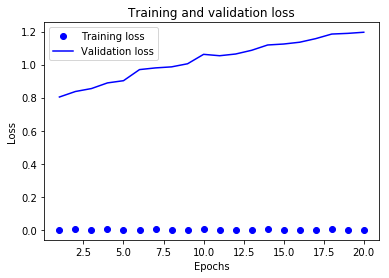

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Slowly begin to overfit the training data, decreasing the generalizability of the model.

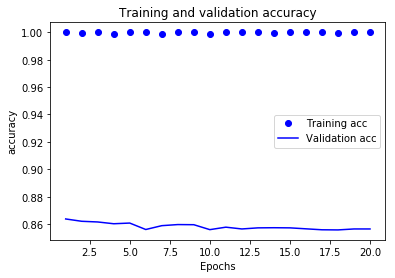

In [17]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

Validation accuracy (generalization accuracy) peack around 2.5, should stop before 2.5 to maximize accuracy on unseen data.

In [18]:
model.predict(x_test)

array([[7.1823597e-06],
       [1.0000000e+00],
       [9.7966099e-01],
       ...,
       [5.0365925e-06],
       [6.4969063e-05],
       [8.2632625e-01]], dtype=float32)